In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   sklearn.linear_model import LinearRegression, LogisticRegression
from   sklearn.preprocessing import StandardScaler
import yfinance as yf

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# TICKER = '^GSPC'
TICKER = '^NYA' 
df = yf.download(TICKER, start='1965-01-01')
df = df[['Open', 'Close', 'Adj Close']]
df.rename(columns={'Adj Close': 'Value'}, inplace=True)
df['Date'] = df.index
df.fillna(method='ffill')
df.index = range(df.shape[0])
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,Close,Value,Date
13741,12612.089844,12731.549805,12731.549805,2020-08-05
13742,12702.879883,12729.169922,12729.169922,2020-08-06
13743,12655.700195,12765.839844,12765.839844,2020-08-07
13744,12797.780273,12844.019531,12844.019531,2020-08-10
13745,12979.075195,12849.370117,12849.370117,2020-08-11


In [3]:
CHANGE_OVER = 5
df.loc[:, f'Change_{CHANGE_OVER}Day'] = np.nan
for i in range(CHANGE_OVER, df.shape[0]):
    df.loc[i, f'Change_{CHANGE_OVER}Day'] = df.loc[i, 'Value'] / df.loc[i - CHANGE_OVER, 'Value']
df.tail(10)

,Open,Close,Value,Date,Change_5Day
13736,12533.459961,12669.620117,12669.620117,2020-07-29,1.008000
13737,12491.459961,12533.280273,12533.280273,2020-07-30,1.001791
13738,12509.330078,12465.049805,12465.049805,2020-07-31,1.000262
13739,12513.209961,12536.809570,12536.809570,2020-08-03,0.998700
13740,12548.929688,12612.110352,12612.110352,2020-08-04,1.009678
13741,12612.089844,12731.549805,12731.549805,2020-08-05,1.004888
13742,12702.879883,12729.169922,12729.169922,2020-08-06,1.015630
13743,12655.700195,12765.839844,12765.839844,2020-08-07,1.024131
13744,12797.780273,12844.019531,12844.019531,2020-08-10,1.024505
13745,12979.075195,12849.370117,12849.370117,2020-08-11,1.018812


In [4]:
def get_macd(series, n_fast=75, n_slow=155, signal=35, years=None, plot=False):
    n = len(series)
    ema_fast = series.ewm(span=n_fast).mean()
    ema_slow = series.ewm(span=n_slow).mean()
    macd = ema_fast - ema_slow
    sig = macd.ewm(span=signal).mean()
    histo = macd - sig
    k = years * 250 if years is not None else n - 1
    if plot:
        plt.plot(macd[n-k:n], color='k', label=f'MACD: {n_fast} - {n_slow}')
        plt.plot(sig, color='r', label=f'Signal: {signal}')
        plt.axhline(0, color='gray')
        plt.plot(histo, color='blue', label='Hist')
        plt.legend();
    return histo

13736    140.233912
13737    140.927173
13738    140.421434
13739    140.610113
13740    141.471214
13741    143.500531
13742    145.029992
13743    146.596890
13744    148.720215
13745    150.412376
Name: Value, dtype: float64


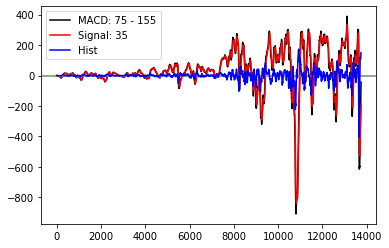

In [5]:
test = get_macd(df.Value, plot=True)
print(test[-10:])

In [6]:
def get_rmse(preds, actual):
    return np.sqrt(((preds - actual)**2).mean())

In [7]:
def get_error(changes, histo, err_type='rmse'):
    histo_changes =  histo.copy()
    for i in range(1, len(histo)):
        histo_changes[i] = histo[i] - histo[i - 1]
    histo = histo[1:-CHANGE_OVER]
    histo_changes = histo_changes[1:-CHANGE_OVER]
    changes = changes[CHANGE_OVER + 1:]
    histo_interaction = histo * histo_changes
    X = np.vstack([histo, histo_changes, histo_interaction]).T
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    if err_type == 'rmse':
        mod = LinearRegression().fit(X, changes)
        preds = mod.predict(X)
        err = get_rmse(preds, changes)
    elif err_type == 'categorical':
        changes = 1 * (changes >= 1.)
        mod = LogisticRegression().fit(X, changes)
        preds = mod.predict(X)
        acc = (preds == changes).sum() / len(changes)
        err = 1 - acc
    return err, mod, preds, scaler

In [78]:
get_error(df[f'Change_{CHANGE_OVER}Day'], test, err_type='categorical')

(0.43886462882096067,
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 array([1, 1, 1, ..., 1, 1, 1]),
 StandardScaler(copy=True, with_mean=True, with_std=True))

In [79]:
get_error(df[f'Change_{CHANGE_OVER}Day'], test)

(0.023039796599543298,
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 array([1.00142092, 1.00142045, 1.00141907, ..., 0.99947456, 0.99955346,
        0.99962207]),
 StandardScaler(copy=True, with_mean=True, with_std=True))

In [80]:
ERR_TYPE = 'rmse'

In [124]:
(160 + 192) / 2

176.0

In [161]:
FAST = [10, 20, 40, 80, 160]
SLOW = [40, 80, 160, 320, 640]
SIGNAL = [16, 32, 64, 128, 256]

FAST = [150, 151, 152]
SLOW = [151, 152, 153]
SIGNAL = [151, 152, 153]

In [162]:
best_error = np.inf
best_params = {'fast': None,
               'slow': None,
               'signal': None}
best_hist = None
best_coefs = None
best_preds = None
best_scaler = None

for f in FAST:
    print('Fast:', f)
    for s in SLOW:
        for g in SIGNAL:
            hist = get_macd(df.Value, n_fast=f, n_slow=s, signal=g)
            error, mod, preds, scaler = get_error(df[f'Change_{CHANGE_OVER}Day'], hist, err_type=ERR_TYPE)
            if error < best_error:
                print(f'  New Best! Error: {error:.9}')
                best_error = error
                best_params['fast'] = f
                best_params['slow'] = s
                best_params['signal'] = g
                best_hist = hist
                best_preds = preds
                best_scaler = scaler

Fast: 150
  New Best! Error: 0.0229907738
  New Best! Error: 0.0229907669
  New Best! Error: 0.022990763
  New Best! Error: 0.0229907628
  New Best! Error: 0.0229907617
  New Best! Error: 0.0229907617
Fast: 151
  New Best! Error: 0.0229907615
Fast: 152


In [163]:
best_params

{'fast': 151, 'slow': 152, 'signal': 152}

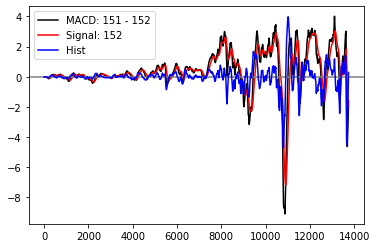

In [164]:
best_hist = get_macd(
    df.Value, n_fast=best_params['fast'], n_slow=best_params['slow'], signal=best_params['signal'], plot=True)

In [165]:
err, mod, best_preds, best_scaler = get_error(df[f'Change_{CHANGE_OVER}Day'], best_hist, err_type=ERR_TYPE)

In [166]:
best_hist_changes =  best_hist.copy()
for i in range(1, len(best_hist)):
    best_hist_changes[i] = best_hist[i] - best_hist[i - 1]
best_hist = best_hist[1:]
best_hist_changes = best_hist_changes[1:]
best_hist_interaction = best_hist * best_hist_changes
X = np.vstack([best_hist, best_hist_changes, best_hist_interaction]).T
X = best_scaler.transform(X)
X

array([[ 1.34687529e-02, -4.71748547e-04, -5.31846129e-03],
       [ 1.34825631e-02,  9.30386665e-04, -5.31847055e-03],
       [ 1.35932344e-02,  4.84483226e-03, -5.31827005e-03],
       ...,
       [ 1.84261285e-01,  3.97274217e+00,  2.85737597e-01],
       [ 2.87727847e-01,  4.18176417e+00,  4.86675799e-01],
       [ 3.88051109e-01,  4.05473403e+00,  6.46245115e-01]])

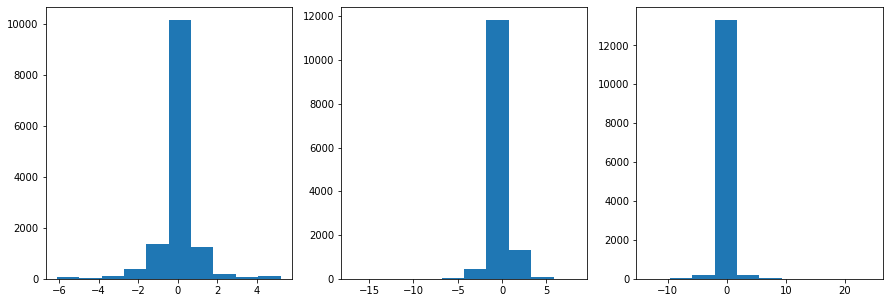

In [167]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.hist(X[:, 0])

plt.subplot(132)
plt.hist(X[:, 1])

plt.subplot(133)
plt.hist(X[:, 2]);

In [168]:
mod

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

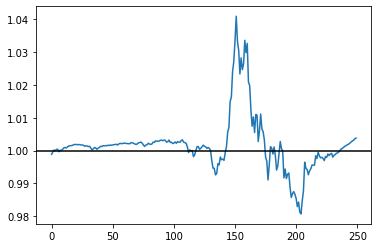

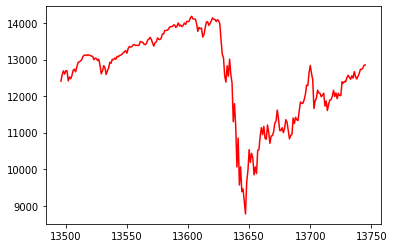

In [173]:
all_preds = mod.predict(X)
plt.plot(all_preds[-250:])
plt.axhline(1, color='k');

plt.figure()
plt.plot(df.Value[-250:], color='r')

In [174]:
X_sub = X[-5:, :]
preds = mod.predict(X_sub)
print(preds)
for i, hist_today in enumerate(best_hist.values[-5:]):
    print(f'Day {i + 1}\n  Hist: {hist_today:2.2f}\n  Pred: {preds[i]}')

[1.00266716 1.00289769 1.00318838 1.00359588 1.00382061]
Day 1
  Hist: -0.02
  Pred: 1.002667162886484
Day 2
  Hist: 0.06
  Pred: 1.0028976868288355
Day 3
  Hist: 0.13
  Pred: 1.0031883833691497
Day 4
  Hist: 0.21
  Pred: 1.0035958792250586
Day 5
  Hist: 0.29
  Pred: 1.0038206104496967


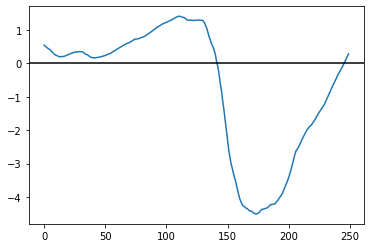

In [175]:
plt.plot(best_hist.values[-250:])
plt.axhline(0, color='k');

In [176]:
best_preds.min(), best_preds.max()

(0.9807099142067373, 1.040943663198191)

In [177]:
qs = np.quantile(best_preds, q=[0.001, 0.999])
qs

array([0.98869716, 1.02353658])

In [178]:
def rescale(x, qs, new_min=0.9, new_center=1, new_max=2):
    if x == 1:
        return new_center
    if x < 1:
        qs[1] = 1
        new_max = new_center
    elif x > 1:
        qs[0] = 1
        new_min = new_center
    #print(qs)
    x -= qs[0]
    x /= (qs[1] - qs[0])
    x *= (new_max - new_min)
    x += new_min
    if x > new_max:
        x = new_max
    if x < new_min:
        x = new_min
    return x

In [179]:
X_today = X[-1, :]
X_today

array([0.38805111, 4.05473403, 0.64624512])

In [180]:
mod.predict([X_today])

array([1.00382061])

In [181]:
pred_today = mod.predict([X_today])
exp_today = rescale(pred_today.copy(), qs)
print(f'TODAY:\nhist: {hist_today}\npred: {pred_today[0]}\nexp:  {exp_today[0]}')

TODAY:
hist: 0.2872088445465246
pred: 1.0038206104496967
exp:  1.1623265036338826
